<a href="https://colab.research.google.com/github/apothula/dl/blob/main/NN/08_Classification_MNIST_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">MNIST Digit Classification using Keras</h1>

In this notebook, we will introduce several new concepts associated with the general problem of classification involving more than two classes. This is sometimes referred to as multinomial regression or softmax regression when the number of classes is more than two. Specifically, in this notebook, we will see how to classify handwritten digits from the MNIST database. The MNIST dataset is included in Tensorflow and can easily be imported and loaded, as we will see below. Using this dataset, we will demonstrate how to work with image data that represents the digits $[0,9]$ and how to develop a network architecture that includes ten neurons whose outputs represent the probability of the digits.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_MNIST_Digits.jpg' width=650 align='center'>



## Table of Contents
* [1 Mathematical Foundation](#1-Mathematical-Foundation)
* [2 Load the MNIST Dataset](#2-Load-the-MNIST-Dataset)
* [3 Prepare the Image Data](#3-Prepare-the-Image-Data)
* [4 Model Architecture](#4-Model-Architecture)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

## 1 Mathematical Foundation

First, recall for **binary classification**, we developed a probabilistic interpretation for the output of the **sigmoid** activation function, $y'$, as follows:

$$P(y\ =\ 1| x;\theta) = y'$$

Here $y'$ represented the probability of class 1 given the input $x$ is associated with class 1. And therefore, the probability that the input sample belongs class 0 (or the negative class) is:

$$P(y\ =\ 0| x;\theta) = 1 - y'$$

We combined these two expressions into a single equation as shown below, where $y$ represents the ground truth (or label) for the class.

$$p(y\ |\ x;\theta) = (y')\ ^y\ (1 - y')^{1-y}$$

In order to extend this to three or more classes, we are going to introduce the **softmax** activation function in the next section.

### 1.1 Softmax Activation Function

For classification problems involving more than two classes the target $y$ is a variable that ranges over more than two classes, and we, therefore, want to know the probability of $y$ being in each potential class $i$.

$$ p(y\ =\ i\ |\ x) = y_i'$$

As we will see further below, when we have three or more classes, the network architecture will contain an output neuron for each class whose output will be the predicted probability that the input $x$ is associated with a particular class, $i$. We can now use a generalization of the sigmoid activation function called the **softmax** function to compute $p(y\ =\ i\ |\ x)$.

The softmax activation function will map each of the neuron inputs to a probability distribution, where each neuron output is a value in the range $(0, 1)$ with all values summing to 1. Assuming the number of possible classes is $k$, the following equation defines the **softmax** function, and the output for any particular neuron with the input $ z_i = w_i^Tx + b_i $ is defined as follows:

$$ softmax(z_i)\ = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}} = y_i', \ \ 1<= i <= k $$

Therefore, each output neuron ($i$) will compute a softmax score according to the above equation. Notice that the numerator is for a given class $i$, and the denominator normalizes each neuron's output into probabilities so that the inputs are mapped to the range $(0,1)$. So each output neuron computes a number in the range $(0,1)$, and the summation of the scores from all neurons is 1. The output of each neuron, $y'_i$, is interpreted as the probability that the input $x$ is associated with class $i$.

### 1.2 Cross Entropy Loss Function

The loss function used for multinomial regression is known as the **Cross Entropy Loss** function and is defined with the same motivation as binary cross entropy loss. Here, we want to maximize the probability that a given input corresponds to a given class $i$ which is the same as minimizing the negative log of the probability. The loss function for a single example $x$ is the sum of the logs of the $k$ output classes:

$$ J(y') = -\sum_{i=1}^{k} 1\{y=i\}\ log\ [\ p(y\ =\ i|x)\ ]$$

$$ J(y') = -\sum_{i=1}^{k} 1\{y=i\}\ log\ [ \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}\ ]$$

$$ J(y') = -\sum_{i=1}^{k} 1\{y=i\}\ log\ [ y'_i ]$$



In the equation above, we make use of the indicator function $1\{\}$ which evaluates to 1 if the condition in the brackets is true and to 0 otherwise. So, the total loss is a summation across each of the output neurons. An easy way to get an intuition for why this makes sense is to consider two cases. First, consider the case where the neuron with the highest output is associated with the ground truth label for the input $x$. In that case, the total loss would be the negative log of a high probability number. For example, if the probability was 0.9 then the total loss for this case would be $-log(0.9) = .105$. Now consider a case where the correct class had a predicted output probability of .01. In that case, the total loss would be the negative log of a low probability number, $-log(0.01) = 4.61$.


## 2 Load the MNIST Dataset

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['image.cmap'] = 'gray'

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# For GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

### <font style="color:rgb(50,120,230)">Load the MNIST dataset and split into train, validation and test</font>

In [3]:
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

X_val   = X_train_all[:10000]
X_train = X_train_all[10000:]
y_val   = y_train_all[:10000]
y_train = y_train_all[10000:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


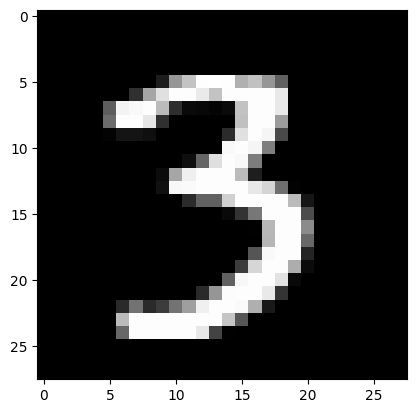

In [4]:
plt.imshow(X_train[0]);

## 3 Prepare the Image Data

We're now going to pre-process the image data by reshaping it from a 2D [28x28] array into a 1D [784x1] array. We will also normalize the intensity values to the range $[0, 1]$.

In [5]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test = X_test.astype("float32") / 255

X_val = X_val.reshape((X_val.shape[0], 28 * 28))
X_val = X_val.astype("float32") / 255

## 4 Model Architecture

### 4.1 Single Layer, Multiple Output Architecture

The network architecture shown below is similar to the previous architecture for binary classification but with some important differences. The key differences are summarized below:

1. The image input data is pre-processed in a way that we have not yet discussed (more on this below).
2. We now have 10 neurons to represent the ten different classes (digits: 0 to 9), instead of a single neuron as with binary classification.
3. The activation function is a **softmax** activation rather than a sigmoid activation.
4. The loss function is now **sparse categorical cross entropy**.

Although the diagram looks quite a bit different from previous (single neuron) architectures, it is fundamentally very similar in terms of the processing that takes place during training and prediction.


<img src='https://learnopencv.com/wp-content/uploads/2022/12/c4_02_MNIST_network_updated.png' width=850 align='center'><br/>

### 4.2 Input Feature Transformation

Since we are now working with an image as the input, we need to find some logical way to represent the image data as a set of features. A naive approach that actually works quite well is to just assume that the pixel intensities **are** the features. And one way to transform the image data into a set of features that we can process is to flatten the 2D array into a 1D array. The 28x28 input image thus becomes a 1D array containing 784 features. Notice that we also normalize the pixel intensities to be in the range $[0, 1]$. This is very common when working with image data. This normalization that we perform manually there preclude the need to define a normalization layer in Keras.

Also, just to be clear, using the pixel intensities as features is a naive approach that we are using intentionally here to keep things simple. As we will see in Module 3, we will learn about convolutional neural networks (CNNs), which use more advanced techniques for representing and processing image data in neural networks.


### 4.3 Fully Connected (Dense) Layers

The neural network architectures we have covered thus far in the course have used "fully connected" layers which are also referred to as "dense" layers. This is very common, but as the number of inputs and neurons in each layer becomes larger, the number of trainable parameters grows exponentially. The figure below shows two examples of fully connected layers. When depicting neural network architectures with fully connected layers, the connections are typically omitted with the understanding that 'dense' or 'fully connected' is assumed.

<img src='https://learnopencv.com/wp-content/uploads/2022/01/c4_02_dense_layers.png' width=700 align='center'>

As we will see later in the course, when working with images, the number of parameters can become exceedingly large as the number of neurons and the number of layers in the network is increased. For example, it is not uncommon for state-of-the-art networks to contain millions of parameters. Larger networks hold the potential to exceed the performance of smaller networks, but that comes at the cost of much longer training times. In order to mitigate these issues, we will see that the data in the network is sometimes down-sampled at intermediate layers, which reduces the number of parameters. One approach that is used to down-sample data in CNNs is called 'pooling.' Another approach called "dropout", is a stochastic regularization technique that is used to reduce overfitting by randomly dropping a percentage of neurons from the network (along with their associated connections) which also reduces the number of trainable parameters in the network. We will cover these topics in more detail later in the course.

### 4.4 Model Architecture Definition

In [6]:
# Instantiate the model.
model = tf.keras.Sequential()

# Add the single neuron.
model.add(Dense(10, input_shape=(784,), activation="softmax"))

# Display the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4.5 Compile the Model

This step defines the optimizer and the loss function that will be used in the training loop.

In [7]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### 4.6 Train the Model

In [8]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    verbose=False,
                    validation_data=(X_val, y_val));

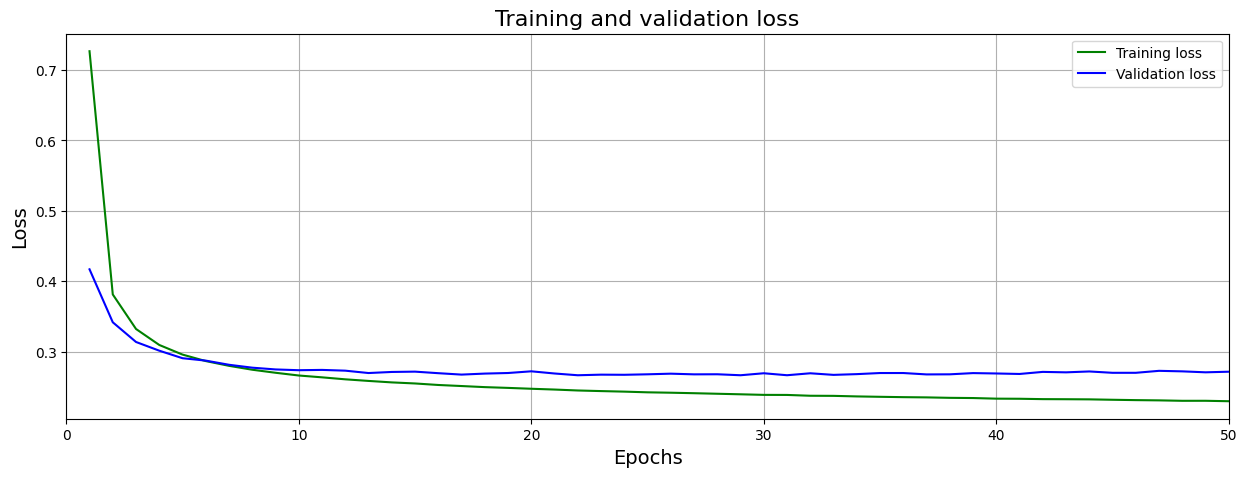

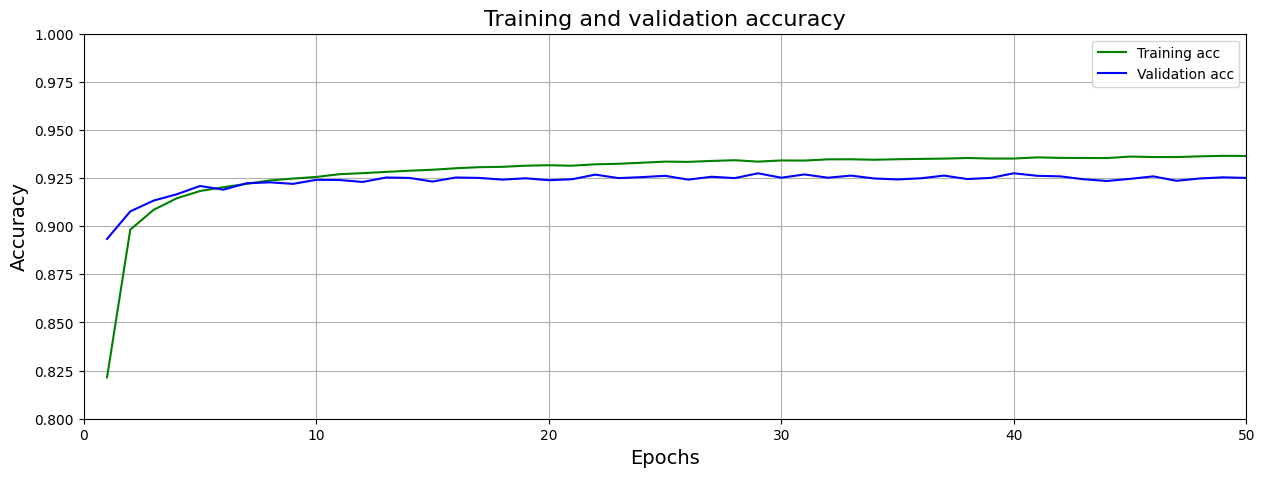

In [9]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=[15, 5])
plt.plot(epochs, loss_values, "g", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 50)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=[15, 5])
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "g", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xlim(0, 50)
plt.ylim(.8, 1.0)
plt.legend()
plt.grid(True)
plt.show()

### 4.7 Saving and Loading Models
Saving and loading models is very convenient. This enables you to develop and train a model, save it to the file system and then load at some future time for use.  In this section we will cover the basic operations for saving and loading models.

### <font style="color:rgb(50,120,230)">Saving models</font>

You can easily save a model using the `save()` method which will save the model to the file system in the 'SavedModel' format. This method creates a folder on the file system. Within this folder, the model architecture and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`. The 'variables/' folder  contains a standard training checkpoint that includes the weights of the model. We will delve into these details in later modules. For now, let's simply save the trained model and then we'll load it in the next code cell with a different name and continue using it in the remainder of the notebook.

In [11]:
# Using the save() method, the model will be saved to the file system in the 'SavedModel' format.
model.save('MNIST_classifer_model')

### <font style="color:rgb(50,120,230)">Loading models</font>
Let's now load the model and continue using it.

In [12]:
from tensorflow.keras import models
MNIST_classifer_model = models.load_model('MNIST_classifer_model')

## 5 Model Evaluation

### 5.1 Make Predictions on Sample Test Images
We can now predict the results for all the test images, as shown in the code below. Here, we call the predict() method to retrieve all the predictions, and then we select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [13]:
predictions = MNIST_classifer_model.predict(X_test)
index = 0 # up to 9999
print('Ground truth for test digit: ',y_test[index])
print('\n');
print('Predictions for each class:\n')
for i in range(10):
    print('digit:', i, ' probability: ', predictions[index][i])

313/313 [==============================] - 1s 2ms/step
Ground truth for test digit:  7


Predictions for each class:

digit: 0  probability:  3.395438e-08
digit: 1  probability:  3.0943506e-14
digit: 2  probability:  2.2111874e-07
digit: 3  probability:  0.0029472793
digit: 4  probability:  9.240908e-08
digit: 5  probability:  3.1810323e-05
digit: 6  probability:  4.2270587e-13
digit: 7  probability:  0.9967475
digit: 8  probability:  8.235778e-06
digit: 9  probability:  0.00026476785


### 5.2 Confusion Matrix

In [14]:
predictions = MNIST_classifer_model.predict(X_test)
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 1s 2ms/step


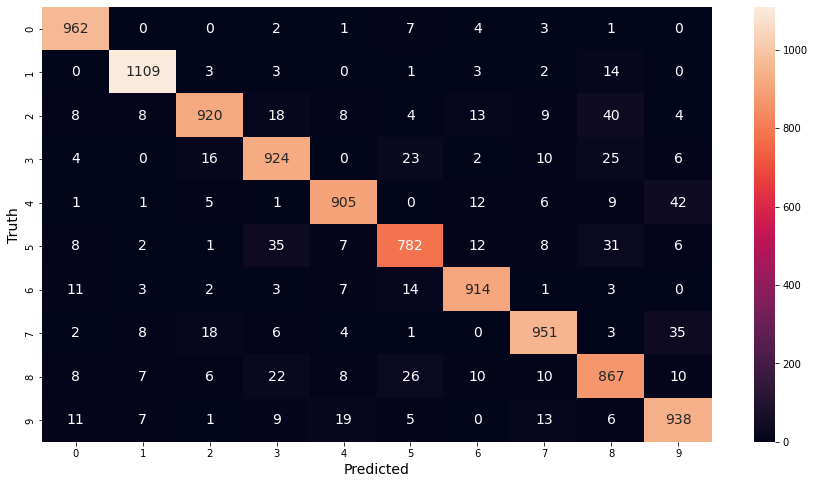

In [ ]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=predicted_labels)

plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

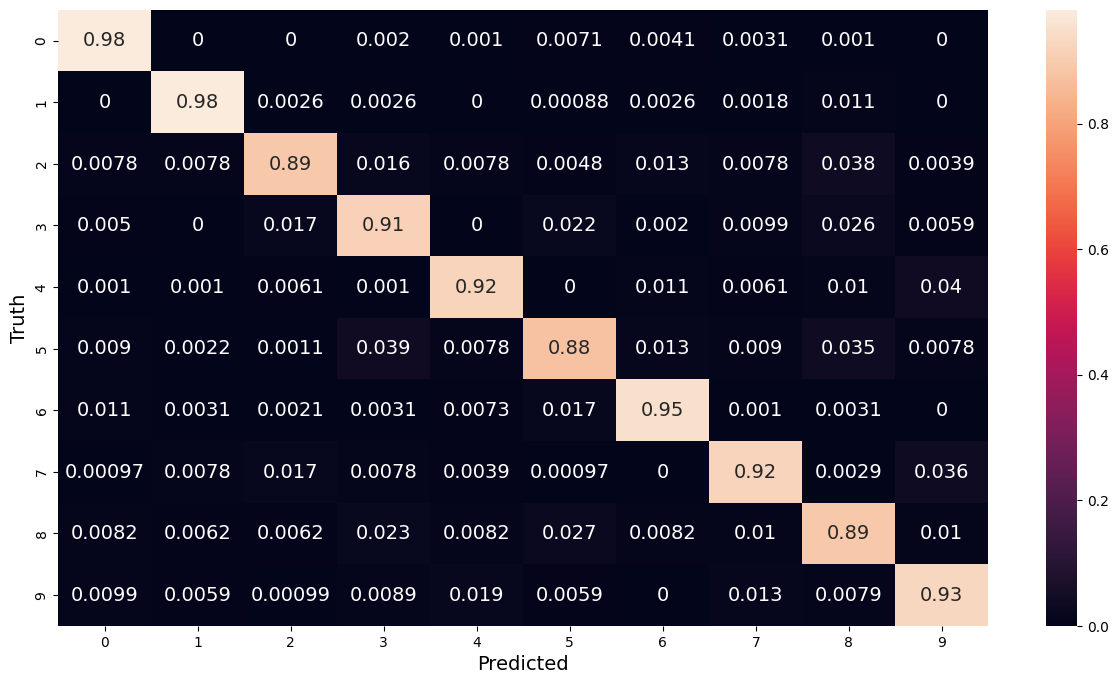

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=predicted_labels, normalize='true')

plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### 5.3 Model Diagnostics: Interpretation of the Weights

We can gain some additional insight as to why the trained weights make sense for detecting each of the nine digits by re-shaping the model weights back into a two-dimensional array. In the plots below, we're displaying the weights for three different neurons corresponding to digits 0, 1 and 2. The dot product between the input image and the weights (plus a bias term) for each of the neurons produces a number which is then converted to a probability via the softmax function.

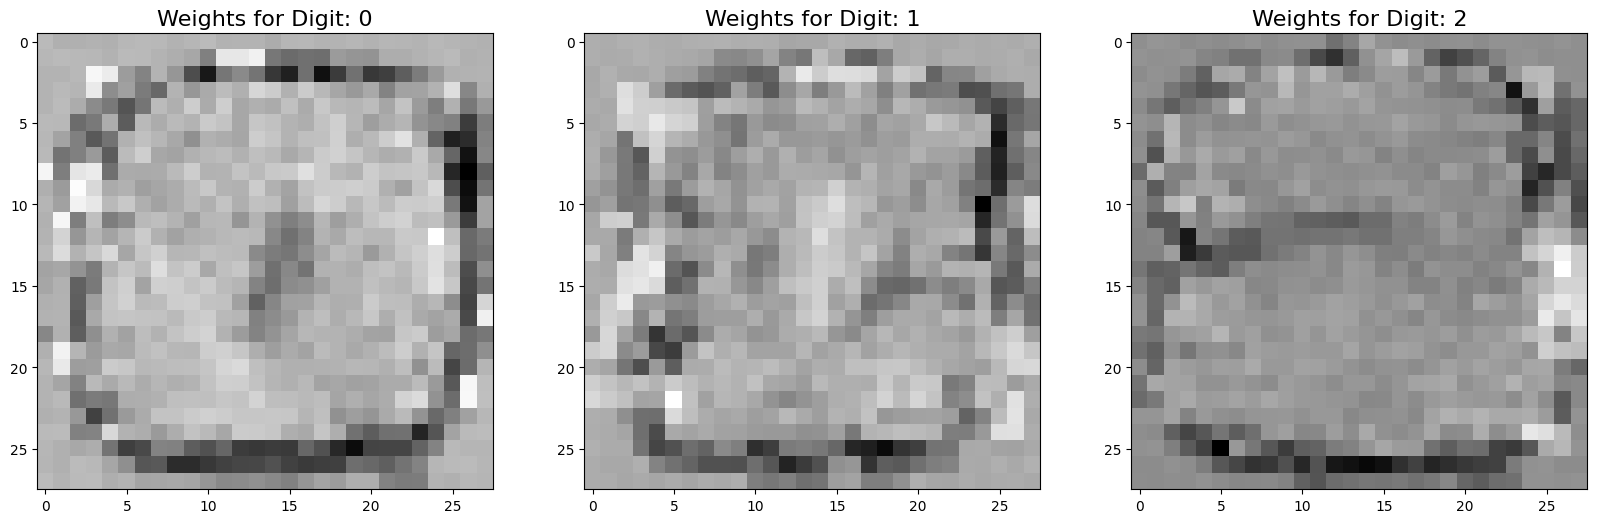

In [16]:
weights = MNIST_classifer_model.layers[0].get_weights()[0]
bias    = MNIST_classifer_model.layers[0].get_weights()[1]

weights_0 = weights[:,0] + bias[0]
weights_0 = np.reshape(weights_0, (28,28))

weights_1 = weights[:,1] + bias[1]
weights_1 = np.reshape(weights_1, (28,28))

weights_2 = weights[:,2] + bias[2]
weights_2 = np.reshape(weights_2, (28,28))

plt.figure(figsize=(20, 7))
plt.subplot(131); plt.title('Weights for Digit: 0'); plt.imshow(weights_0)
plt.subplot(132); plt.title('Weights for Digit: 1'); plt.imshow(weights_1)
plt.subplot(133); plt.title('Weights for Digit: 2'); plt.imshow(weights_2);

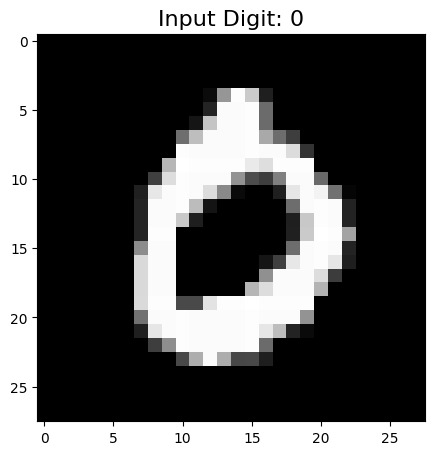

In [17]:
plt.figure(figsize=(17,6))
input_0 = np.reshape(X_test[3], (28,28))
plt.subplot(131); plt.title('Input Digit: 0'); plt.imshow(input_0);

### 6 Conclusions

In this notebook, we introduced multinomial classification, which is an extension to binary classification that uses the softmax activation function. We also introduced one (simple) approach for how to preprocess image data for use in a neural network. In the next module we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well known CNN architectures, which is a great place to start getting familiar with them.

https://tensorspace.org/html/playground/lenet.html